# This notebook pulls in data from the NOAA CO-OPS NWLON stations and pulls in CORA data at those locations from the NOAA Open Data Dissemination (NODD) and plots water level time series for comparison.

# Example
- Time: 2022-01-01 to 2022-01-31
- NOAA hourly
  - Location: Battery park
  - Station ID: 8518750
  - type: waterlevels
  - units metric
- CORA
  - Location: nearest 3 nodes Battery park
  - Nodes: [1266675, 1266674, 1260240]
  - MSL
  - m

## Import your python libraries.

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask
import intake
import xarray as xr
import scipy.spatial as sp
import s3fs
# import geopy.distance
from scipy.spatial import KDTree
# import folium
# from folium import Marker
# from folium.plugins import HeatMap, MarkerCluster
# from branca.colormap import linear, LinearColormap

**Access the data on the NODD and initialize the available CORA datasets.** 

*This accesses a .yml file located on the NODD that shows which CORA output files are available to import.*

In [2]:
# @title This accesses a .yml file located on the NODD that shows which CORA output files are available to import.
catalog = intake.open_catalog("s3://noaa-nos-cora-pds/CORA_intake.yml",storage_options={'anon':True})
list(catalog)

['CORA-V1-fort.63',
 'CORA-V1-maxele.63',
 'CORA-V1-fort.64',
 'CORA-V1-500m-grid-1979-2022']

**CORA-V1.1-fort.63: Hourly water levels <br>
CORA-V1.1-swan_DIR.63: Hourly mean wave direction <br>
CORA-V1.1-swan_TPS.63: Hourly peak wave periods <br>
CORA-V1.1-swan_HS.63: Hourly significant wave heights <br>
CORA-V1.1-Grid: Hourly water levels interpolated from model nodes to uniform 500-meter resolution grid <br>
All datasets denoted as timeseries are optimized for pulling long time series (greater than a few days) <br>
For up to a few days of data, use the regular dataset (not labeled timeseries)**

*Now, create an xarray dataset for the CORA data that you would like to use.*

In [3]:
ds = catalog["CORA-V1-fort.63"].to_dask()

/Users/ylpan/anaconda3/envs/cr-CORA-0204/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [4]:
# stationpointsfile = 'C:\\Users\\John.Ratcliff\\CORA\\HSOFS_GEC_Stations.csv'
# cora_stations = pd.read_csv(stationpointsfile)
# cora_stations['id'] = cora_stations['id'].astype(str)
# cora_stations.iloc[62]

**Create a dataframe of NWLON station ids and coordinates from the CO-OPS API where you want to do a comparison.**

In [5]:
units= 'metric'

station_type = 'waterlevels'

server = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/'

myurl = (server + '.json?type='+station_type+'&units='+units)

urlResponse = requests.get(myurl)
content=urlResponse.json()

stations = content['stations']
stations_df = pd.DataFrame(stations)

stations_df = stations_df[['id','lat','lng']]
# station_id = ['8665530','8670870']
station_id = ['8518750']

stations_df = stations_df[stations_df['id'].isin(station_id)]

stations_df

,id,lat,lng
37,8518750,40.700554,-74.01417


**Loop through the station list to grab water level hourly heights for each station. Create a pandas dataframe of the time series data.**

In [6]:
dataserver = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?'
startend = 'begin_date=20220101&end_date=20220131&'
product = 'product=hourly_height&'
datum = 'datum=MSL&'
time_zone = 'time_zone=gmt&'
units = 'units=metric&'
format = 'format=json'

for i in range(0,len(stations_df)):

  station = 'station=' + stations_df.id.iloc[i] + '&'
  dataurl = dataserver + startend + station + product + datum + time_zone + units + format
  print(dataurl)
  urlResponse = requests.get(dataurl)
  content=urlResponse.json()

  # The API returns a list of dictionaries, each with scalar values.
  # We need to convert this structure into a list of lists or a list of dictionaries with list values
  # before creating a DataFrame.

  # Extracting data for 'time' and 'height'
  time_data = [d['t'] for d in content['data']]
  height_data = [d['v'] for d in content['data']]

  # Convert height_data to numeric using a list comprehension
  height_data = [float(x) for x in height_data]

  # Creating DataFrame if it's the first iteration
  if i == 0:
      df = pd.DataFrame({'time': time_data, 'height_' + stations_df.id.iloc[i]: height_data})
  # Appending 'height' data to existing DataFrame for subsequent iterations
  else:
      df['height_' + stations_df.id.iloc[i]] = height_data  # Append new height column
df.set_index('time', inplace=True)
df


https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20220101&end_date=20220131&station=8518750&product=hourly_height&datum=MSL&time_zone=gmt&units=metric&format=json


,height_8518750
time,
2022-01-01 00:00,0.839
2022-01-01 01:00,0.521
2022-01-01 02:00,0.143
2022-01-01 03:00,-0.203
2022-01-01 04:00,-0.446
...,...
2022-01-31 19:00,-1.061
2022-01-31 20:00,-0.919
2022-01-31 21:00,-0.450


In [7]:
def area(x1, y1, x2, y2, x3, y3):
 
    return (abs((x1 * (y2 - y3) + x2 * (y3 - y1)
                + x3 * (y1 - y2)) / 2.0))

In [8]:
def define_kd_tree(ds):
    e = ds.element.values.astype(int)
    emin1 = e-1
    num_elems = len(e)
    x_vals = ds.x.values
    y_vals = ds.y.values

    xe=np.mean(x_vals[emin1],axis=1)
    ye=np.mean(y_vals[emin1],axis=1)
    tree = sp.KDTree(np.c_[xe,ye])
    areas = [area(x_vals[emin1[k][0]],y_vals[emin1[k][0]],\
                  x_vals[emin1[k][1]],y_vals[emin1[k][1]],\
                  x_vals[emin1[k][2]],y_vals[emin1[k][2]])for k in range(0, num_elems)]
    return tree, areas, e, x_vals, y_vals

In [9]:
def find_triangle(x_vals, y_vals, e,lat,lon):
    e = ds.element.values.astype(int)-1
    
    k = 10
    dist, ii = tree.query([lon,lat],k=k)
    ii = ii
    triangle_i = -1

    for i in range(0,k):

      a1 = area(lon,lat,\
                x_vals[e[ii[i]][0]],y_vals[e[ii[i]][0]],\
                x_vals[e[ii[i]][1]],y_vals[e[ii[i]][1]])

      a2 = area(lon,lat,\
                x_vals[e[ii[i]][1]],y_vals[e[ii[i]][1]],\
                x_vals[e[ii[i]][2]],y_vals[e[ii[i]][2]])
      a3 = area(lon,lat,\
                x_vals[e[ii[i]][0]],y_vals[e[ii][i][0]],\
                x_vals[e[ii[i]][2]],y_vals[e[ii][i][2]])

      t_area = a1 + a2 + a3
      if abs(t_area - areas[ii[i]]) < 0.00000001:
        triangle_i = ii[i]+1
        break
    if(triangle_i == -1):
        print("ERROR for " ,lat,lon)
    return triangle_i

In [10]:
tree, areas, e, x_vals, y_vals = define_kd_tree(ds)  

In [11]:
# Extract node coordinates from the mesh

node_coords = np.c_[ds.x.values, ds.y.values]

kdtree = KDTree(node_coords) # Build the kdtree that can be queried for nearest neighbor nodes to a geographic point

# Initialize
elem = np.zeros((len(stations_df), 1), dtype=int)
elem_nodes = np.zeros((len(stations_df), 3), dtype=int)
query_point = np.zeros((len(stations_df), 2))  # Assuming you want 2 columns for lat and lon
distances = np.zeros((len(stations_df), 3))    # Assuming you want 3 nearest neighbors
nearest = np.zeros((len(stations_df), 3), dtype=int)  # Assuming you want 3 nearest neighbors
dist = np.zeros((len(stations_df), 3), dtype=float)
weights = np.zeros((len(stations_df), 3), dtype=float)

for i in range(0,len(stations_df)):

    elem[i,:] = find_triangle(x_vals,y_vals,e,stations_df.lat.iloc[i],stations_df.lng.iloc[i])
    distances[i,:], nearest[i,:] = kdtree.query([stations_df.lng.iloc[i],stations_df.lat.iloc[i]], k=3)
    nearest[i,:] = nearest[i,:] + 1
    
    if elem[i]==-1:
        elem_nodes[i,:] = nearest[i,:]
    else:
        elem_nodes[i,:] = e[elem[i]-1]

    x_dist = stations_df.lng.iloc[i] - x_vals[elem_nodes[i,:]]
    y_dist = stations_df.lat.iloc[i] - y_vals[elem_nodes[i,:]]
    dist[i,:] = np.sqrt(x_dist * x_dist + y_dist * y_dist)
    
    if np.any(dist[i,:] ==0):
        weights[i,:] = np.where(dist[i,:] == 0, 1, 0)
    else:
        weights[i,:] = 1/dask.array.sqrt(x_dist * x_dist + y_dist * y_dist)

unique_nodes = np.unique(elem_nodes) # sorted unique nodes
mapped_triangle = np.searchsorted(unique_nodes, elem_nodes) # indices of the nodes


In [12]:
unique_nodes[mapped_triangle]

array([[1266675, 1266674, 1260240]])

In [13]:
concat_nodes=np.concatenate(node_coords[elem_nodes-1], axis=0)
lat_nodes=concat_nodes[:,1]
lon_nodes=concat_nodes[:,0]

df_nodes=pd.DataFrame({'Lon': lon_nodes, 'Lat': lat_nodes})
df_nodes

,Lon,Lat
0,-74.017496,40.700781
1,-74.012954,40.699410
2,-74.014863,40.704047


In [14]:
# # Create a base map centered on the first coordinate
# map_center = [stations_df['lat'].iloc[0], stations_df['lng'].iloc[0]]
# my_map = folium.Map(location=map_center, zoom_start=8)

# # Add markers for each coordinate
# for index, row in df_nodes.iterrows():
#     folium.CircleMarker(
#         location=[row['Lat'], row['Lon']],
#     ).add_to(my_map)

# for index, row in stations_df.iterrows():
#     folium.CircleMarker(
#         location=[row['lat'], row['lng']],
#         popup=row['id'], color='red'
#     ).add_to(my_map)

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = False,
#         control = True
#        ).add_to(my_map)

# # Save the map to an HTML file
# # my_map.save("nodesmap.html")

# my_map

**Average the water levels at the 3 nodes of the element containing the station coordinates for the selected time period. Append these CORA values as new columns to the dataframe.**

In [15]:
%%time

start_t = "2022-01-01 00:00:00"
end_t = "2022-01-31 23:00:00"
dt_range=pd.date_range(start_t, end_t, freq='h',inclusive='both')

num_ts = len(dt_range) # number of time samples
t = np.zeros((num_ts, 3), dtype=float) # preallocate with zeros
zeta_point = np.zeros((num_ts), dtype=float) # preallocate with zeros
mean_zeta = np.zeros((num_ts,len(stations_df)), dtype=float)

for i in range(0,len(stations_df)):
    zeta_tslice = ds["zeta"].sel(time=slice(start_t, end_t), node=unique_nodes[mapped_triangle[i]]-1).compute()
    t = zeta_tslice.values * weights[i]
    zeta_point = np.sum(t, axis=1) / np.sum(weights[i])
    mean_zeta_i = np.nanmean(zeta_tslice.values, axis=1)

    zeta_point[np.isnan(zeta_point)] = mean_zeta_i[np.isnan(zeta_point)]
    
    df['cora_'+stations_df.iloc[i,0]] = zeta_point


CPU times: user 2.65 s, sys: 1.65 s, total: 4.3 s
Wall time: 19.5 s


In [25]:
df_combined = df.reset_index()[['time', 'height_8518750', 'cora_8518750']]
df_combined

,time,height_8518750,cora_8518750
0,2022-01-01 00:00,0.839,0.753624
1,2022-01-01 01:00,0.521,0.472556
2,2022-01-01 02:00,0.143,0.102508
3,2022-01-01 03:00,-0.203,-0.190965
4,2022-01-01 04:00,-0.446,-0.448162
...,...,...,...
739,2022-01-31 19:00,-1.061,-1.018176
740,2022-01-31 20:00,-0.919,-0.754028
741,2022-01-31 21:00,-0.450,-0.314232
742,2022-01-31 22:00,0.029,0.073081


**Plot the time series data for the NWLON observations and CORA for comparison.**

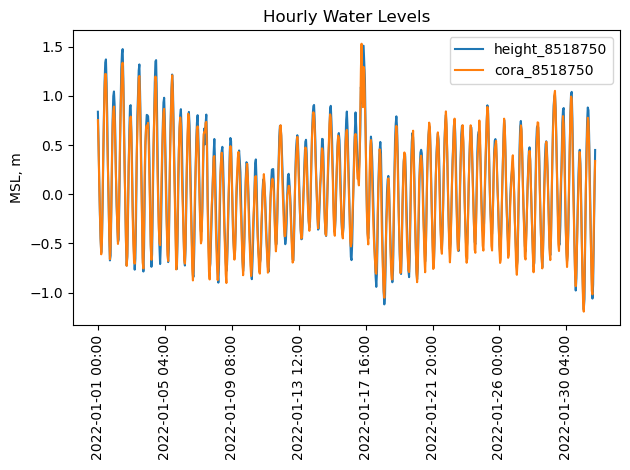

In [26]:
title = "Hourly Water Levels"
ylabel = "MSL, m"
# num_plots = min(zeta_df.shape[1], len(stations_df))
for i in range(0,len(stations_df)):
  df[['height_'+stations_df.id.iloc[i],'cora_'+stations_df.iloc[i,0]]].plot()

  plt.title(title)
  plt.xlabel('')
  plt.ylabel(ylabel)
  plt.xticks(rotation=90)
  plt.tight_layout()
plt.show()

In [27]:
cora_df = df_combined[['time', 'cora_8518750']]
cora_df.rename(columns={'time': 'date', 'cora_8518750': 'WaterLevel'}, inplace=True)
cora_df

/var/folders/8f/3g1vyjkx4vx5trj78yg69khm0000gn/T/ipykernel_90936/1807194503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cora_df.rename(columns={'time': 'date', 'cora_8518750': 'WaterLevel'}, inplace=True)


,date,WaterLevel
0,2022-01-01 00:00,0.753624
1,2022-01-01 01:00,0.472556
2,2022-01-01 02:00,0.102508
3,2022-01-01 03:00,-0.190965
4,2022-01-01 04:00,-0.448162
...,...,...
739,2022-01-31 19:00,-1.018176
740,2022-01-31 20:00,-0.754028
741,2022-01-31 21:00,-0.314232
742,2022-01-31 22:00,0.073081


In [38]:
era5_df = pd.read_csv('era5.csv')
print(era5_df.head())

   temperature  specific_humidity  longitude  latitude
0    282.56952           0.007179      40.75     286.0
1    282.41983           0.007194      40.75     286.0
2    282.26117           0.007183      40.75     286.0
3    282.11597           0.007143      40.75     286.0
4    282.05160           0.007127      40.75     286.0


In [39]:
combined_df = cora_df[['date', 'WaterLevel']]
combined_df['temperature'] = era5_df['temperature']
combined_df['specific_humidity'] = era5_df['specific_humidity']

combined_df

,date,WaterLevel,temperature,specific_humidity
0,2022-01-01 00:00,0.753624,282.56952,0.007179
1,2022-01-01 01:00,0.472556,282.41983,0.007194
2,2022-01-01 02:00,0.102508,282.26117,0.007183
3,2022-01-01 03:00,-0.190965,282.11597,0.007143
4,2022-01-01 04:00,-0.448162,282.05160,0.007127
...,...,...,...,...
739,2022-01-31 19:00,-1.018176,268.47687,0.001247
740,2022-01-31 20:00,-0.754028,269.38600,0.001144
741,2022-01-31 21:00,-0.314232,269.33940,0.001117
742,2022-01-31 22:00,0.073081,269.33940,0.001117


In [ ]:
# combined_df.set_index('date').to_xarray().to_netcdf("/Users/ylpan/Documents/GitHub/ML-ADCIRC/data/time_series/8518750.nc")